In [24]:
import torch
import pickle
import matplotlib.pyplot as plt
from torch.fft import ifftn, fftn, fftshift
from torchvision.utils import make_grid
from torch import nn
import numpy as np

with open(
        '/itet-stor/peerli/net_scratch/sample_varianceCPU.obj',
        #"/Users/lionelpeer/Downloads/sample_varianceCPU.obj",
        'rb'
    ) as f:
    outs = pickle.load(f)
# for key,val in outs.items():
#     outs[key] = outs[key][::25]

# Looking at some Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


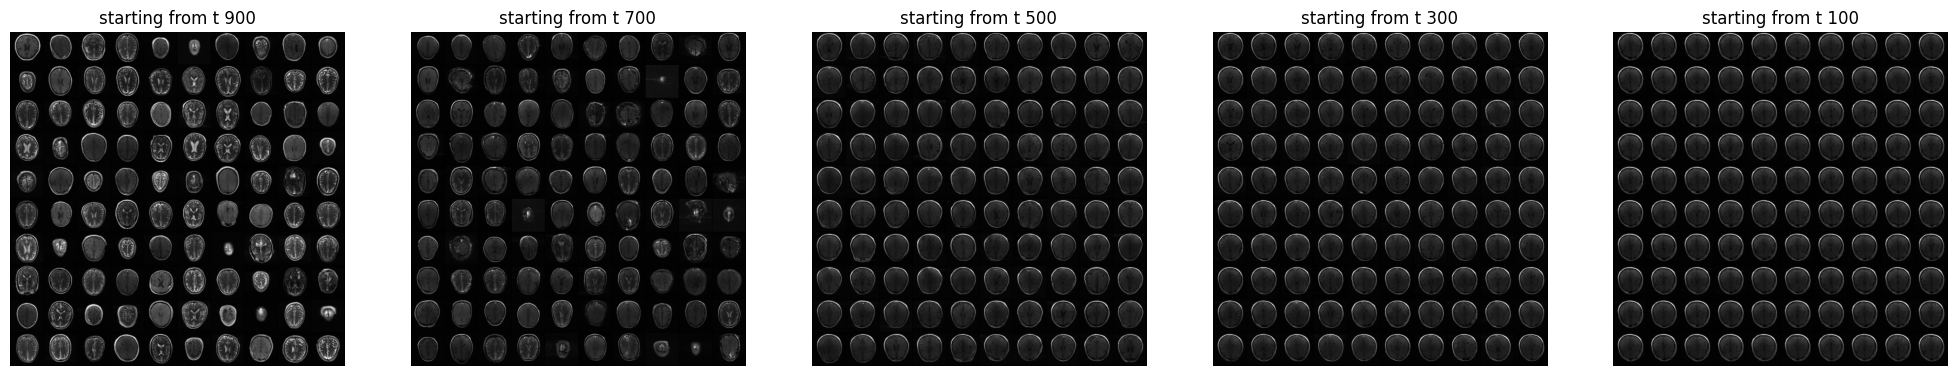

In [25]:
t = [900, 700, 500, 300, 100]
fig, ax = plt.subplots(1,5,figsize=(25,5))
rows = int(np.sqrt(outs[100].shape[0]))

ax[0].imshow(make_grid(outs[t[0]], nrow=rows).permute(1,2,0))
ax[0].set_title(f"starting from t {t[0]}")

ax[1].imshow(make_grid(outs[t[1]], nrow=rows).permute(1,2,0))
ax[1].set_title(f"starting from t {t[1]}")

ax[2].imshow(make_grid(outs[t[2]], nrow=rows).permute(1,2,0))
ax[2].set_title(f"starting from t {t[2]}")

ax[3].imshow(make_grid(outs[t[3]], nrow=rows).permute(1,2,0))
ax[3].set_title(f"starting from t {t[3]}")

ax[4].imshow(make_grid(outs[t[4]], nrow=rows).permute(1,2,0))
ax[4].set_title(f"starting from t {t[4]}")

for elem in ax:
    elem.axis("off")

# Image Means and Variances

Text(0.5, 1.0, 'Image variances (startgin between t=10 and t=990)')

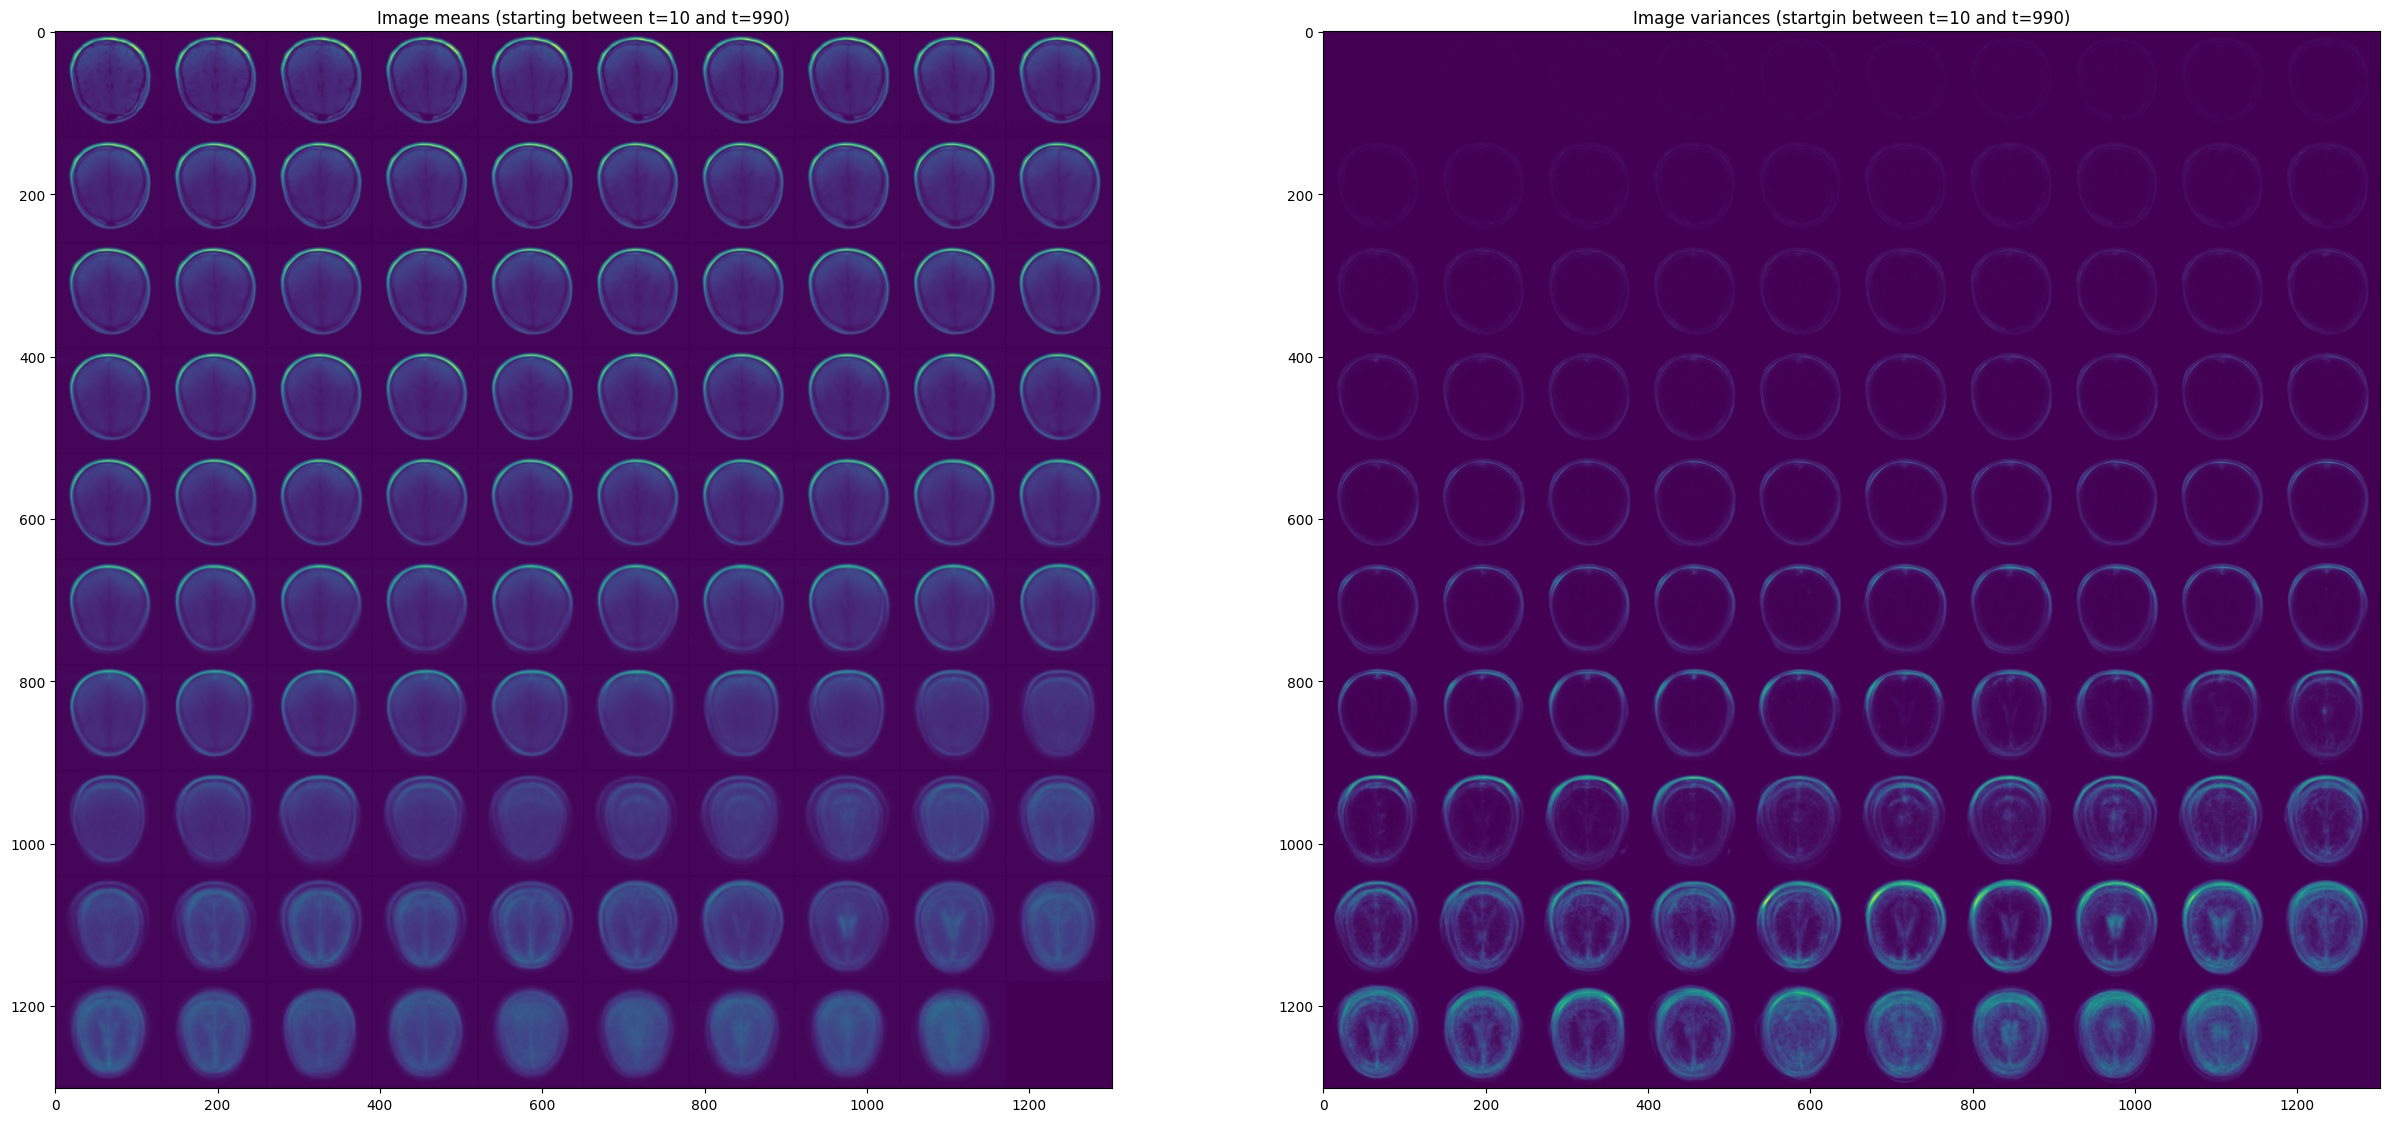

In [26]:
vars = torch.zeros((99,1,128,128))
means = torch.zeros((99,1,128,128))
for key, val in outs.items():
    means[key//10-1] = torch.mean(val, dim=0)
    vars[key//10-1] = torch.var(val, dim=0)

fig, ax = plt.subplots(1,2, figsize=(30,15))
ax[0].imshow(make_grid(means, nrow=10)[0], cmap="viridis")
ax[0].set_title("Image means (starting between t=10 and t=990)")
ax[1].imshow(make_grid(vars, nrow=10)[0], cmap="viridis")
ax[1].set_title("Image variances (startgin between t=10 and t=990)")

# Spectra Means and Variances

Text(0.5, 1.0, 'Spectra log variances (starting between t=10 and t=990)')

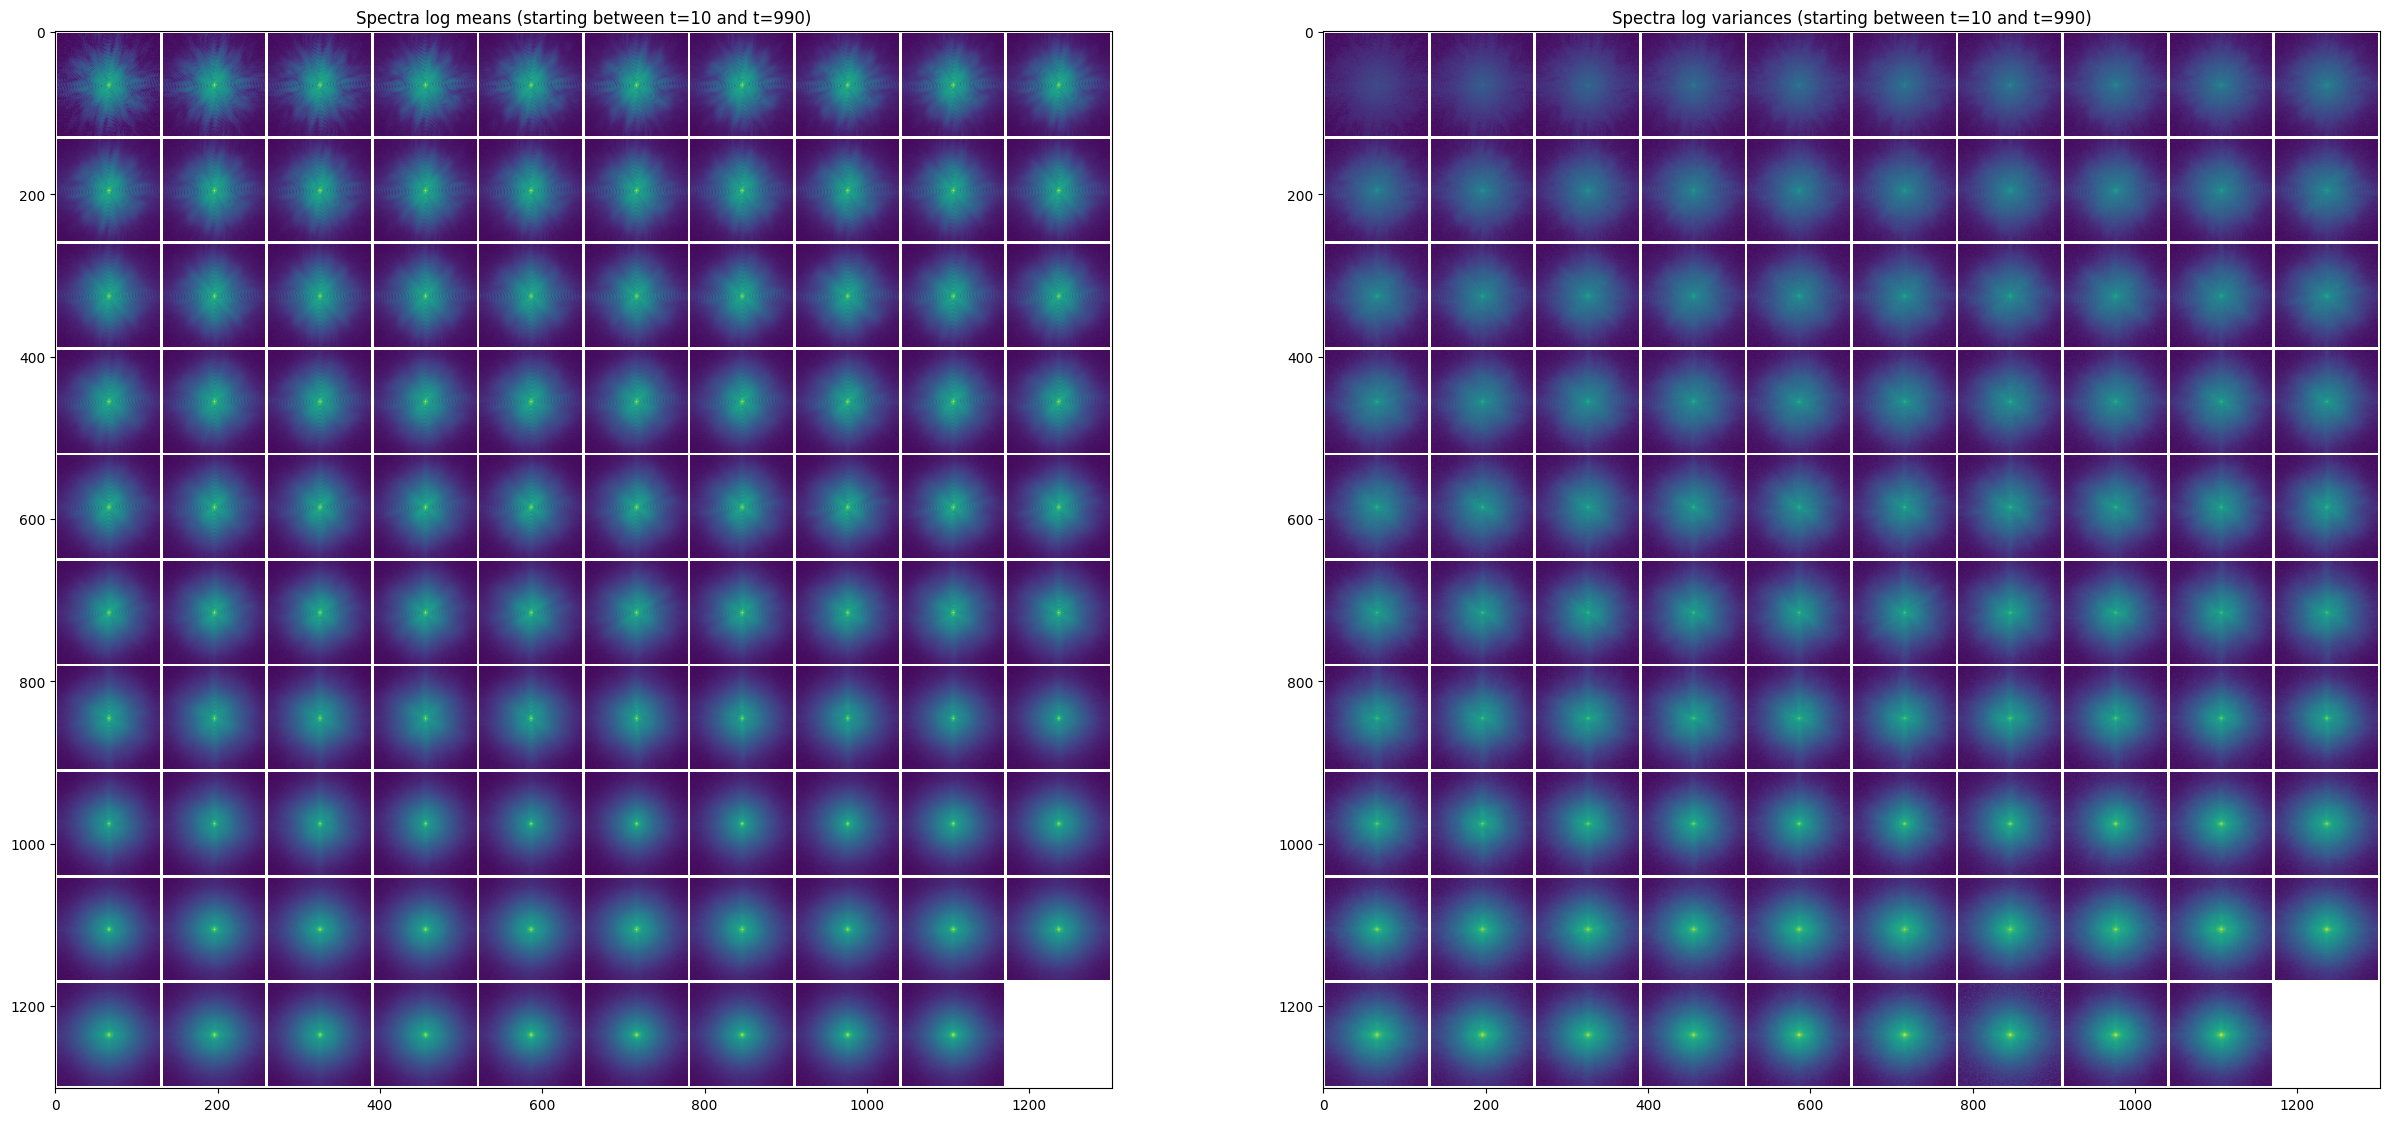

In [27]:
vars = torch.zeros((99,1,128,128))
means = torch.zeros((99,1,128,128))
for key, val in outs.items():
    val = torch.abs(fftshift(fftn(val, dim=(2,3)), dim=(2,3)))
    means[key//10-1] = torch.mean(val, dim=0)
    vars[key//10-1] = torch.var(val, dim=0)

fig, ax = plt.subplots(1,2, figsize=(30,15))
ax[0].imshow(torch.log(make_grid(means, nrow=10)[0]), cmap="viridis")
ax[0].set_title("Spectra log means (starting between t=10 and t=990)")
ax[1].imshow(torch.log(make_grid(vars, nrow=10)[0]), cmap="viridis")
ax[1].set_title("Spectra log variances (starting between t=10 and t=990)")

In [47]:
vars.shape

torch.Size([99, 1, 128, 128])

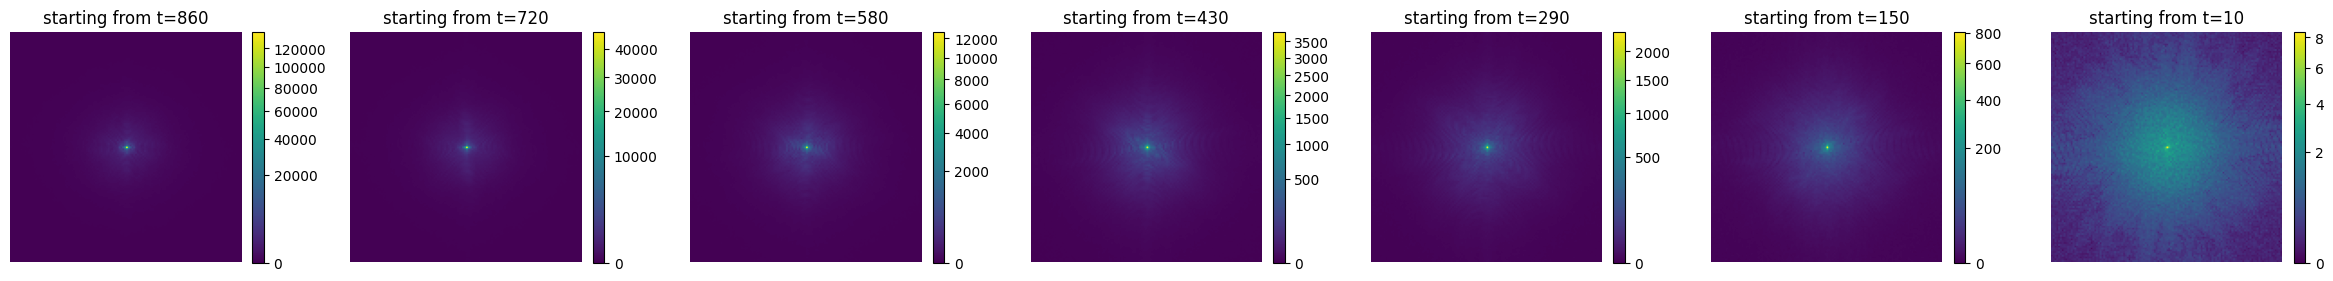

In [64]:
from matplotlib import colors

fig, axs = plt.subplots(1,7, figsize=(30,3))
for i,ax in enumerate(axs[::-1]):
    i = i*100//7
    t = (i+1)*10
    k = ax.imshow(vars[i][0], norm=colors.PowerNorm(0.5))
    plt.colorbar(k, fraction=0.046, pad=0.04)
    ax.axis("off")
    ax.set_title(f"starting from t={t}")

Text(0.5, 1.0, 'Cumulative spectra variances for t in [10,990]')

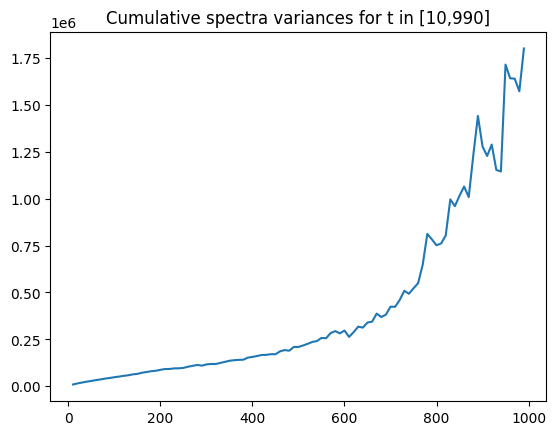

In [60]:
fig, ax = plt.subplots()
sums = torch.sum(vars, dim=(1,2,3))
x = torch.linspace(10, 990, vars.shape[0])
ax.plot(x, sums)
ax.set_title("Cumulative spectra variances for t in [10,990]")

Text(0.5, 1.0, 'Spectra log variances differences between current timestep and previous timestep (starting between t=10 and t=990)')

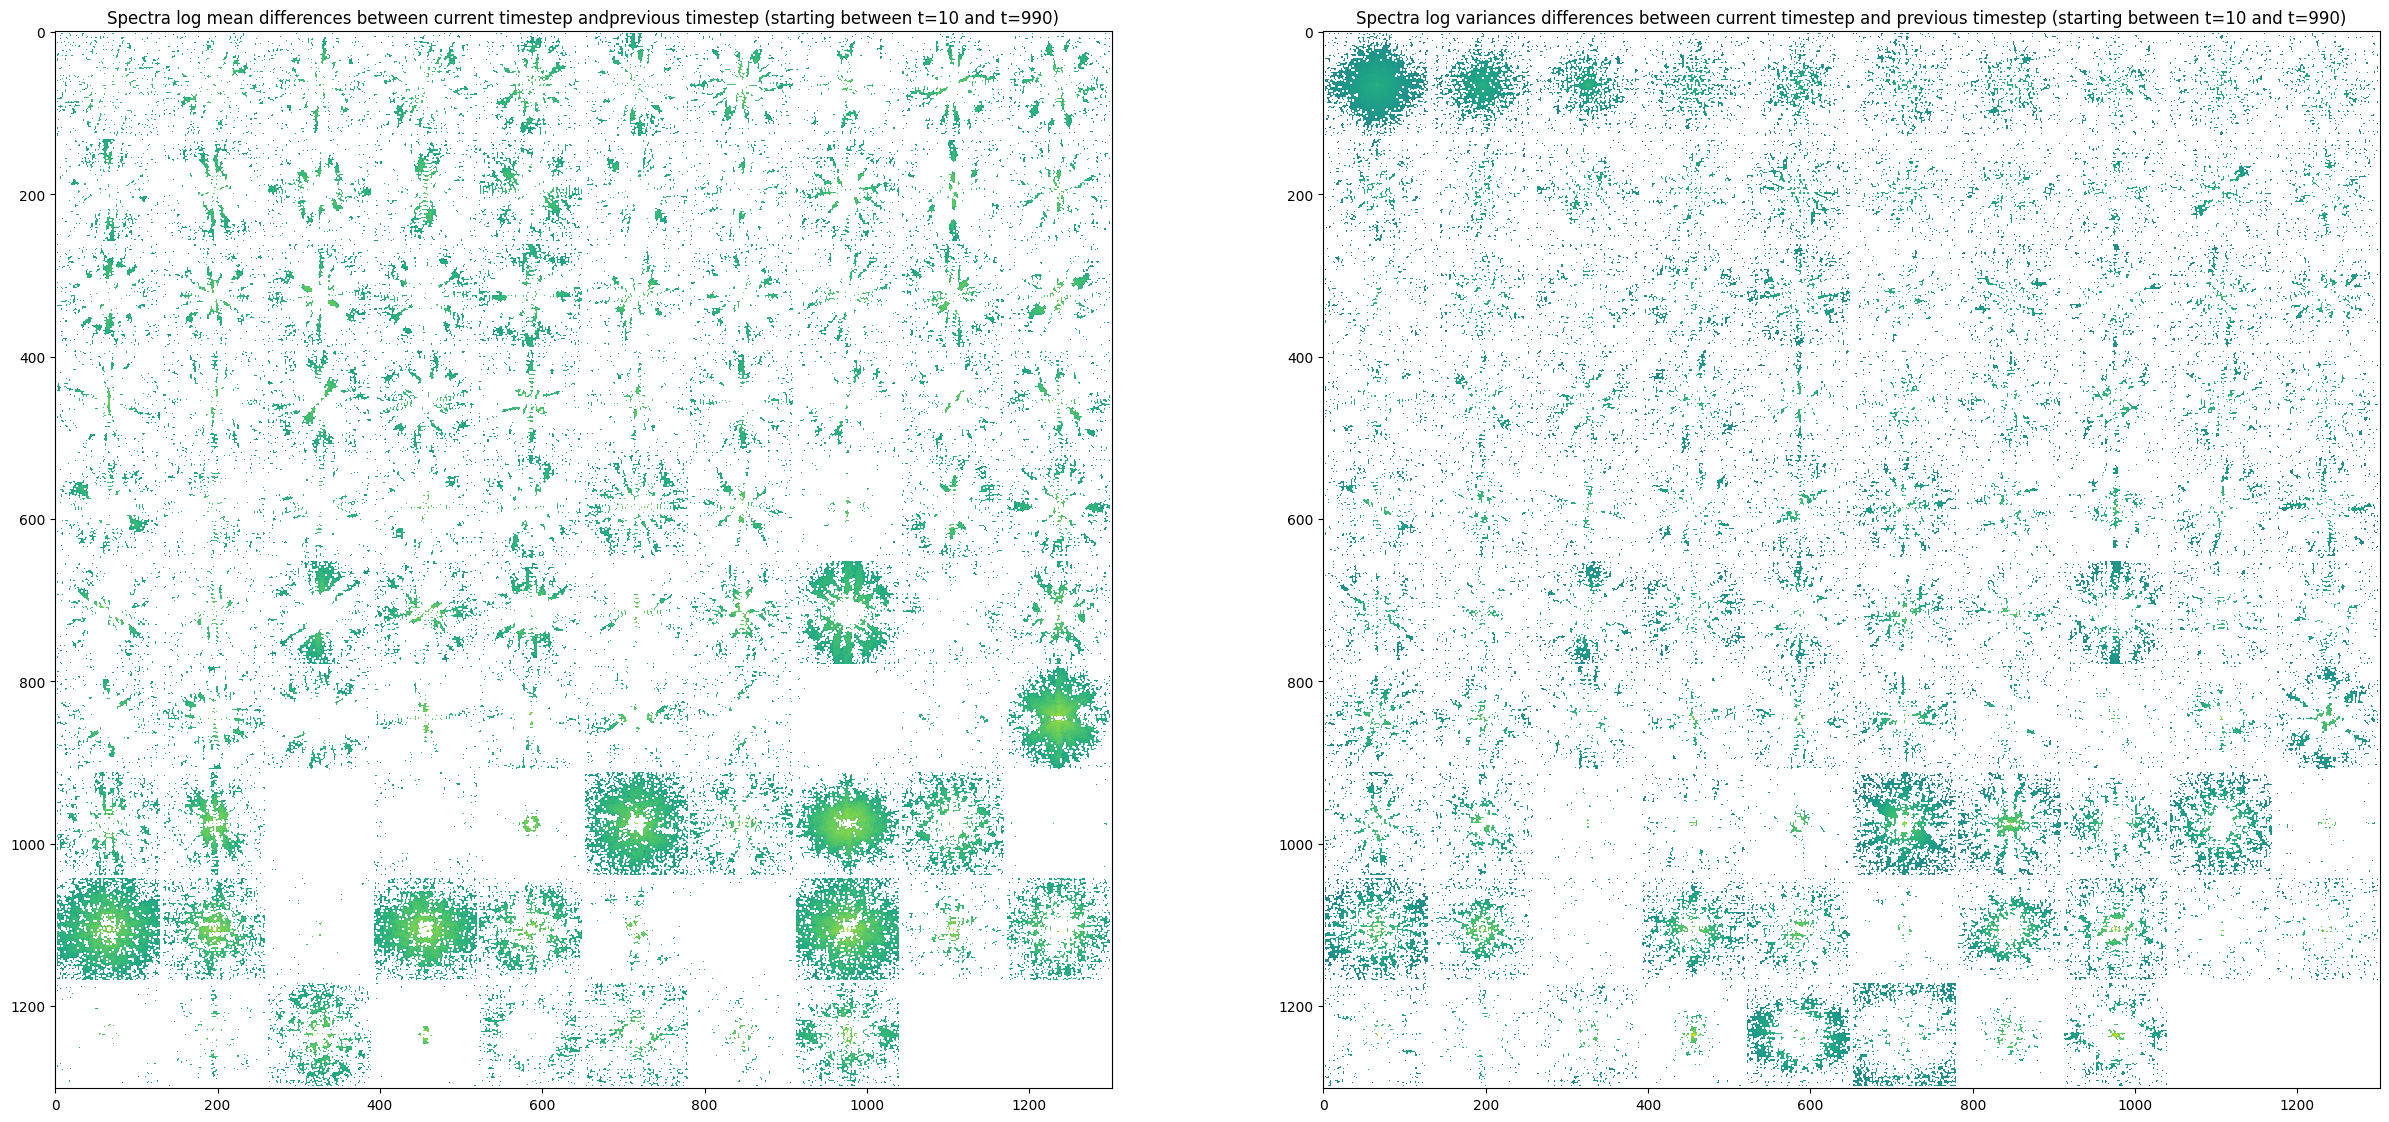

In [15]:
var_diffs = torch.zeros((99,1,128,128))
mean_diffs = torch.zeros((99,1,128,128))
mean0 = torch.zeros((1,128,128))
var0 = torch.zeros((1,128,128))

for (key0, val0), (key1, val1) in zip(list(outs.items())[:-1], list(outs.items())[1:]):
    val0 = torch.abs(fftshift(fftn(val0, dim=(2,3)), dim=(2,3)))
    val1 = torch.abs(fftshift(fftn(val1, dim=(2,3)), dim=(2,3)))

    mean0 = torch.mean(val0, dim=0)# + mean0
    mean1 = torch.mean(val1, dim=0)
    var0 = torch.var(val0, dim=0)# + var0
    var1 = torch.var(val1, dim=0)

    mean = mean0 - mean1
    var = var0 - var1

    mean_diffs[key1//10-1] = mean
    var_diffs[key1//10-1] = var

fig, ax = plt.subplots(1,2, figsize=(30,15))
ax[0].imshow(torch.log(make_grid(mean_diffs, nrow=10))[0], cmap="viridis")
ax[0].set_title("Spectra log mean differences between current timestep andprevious timestep (starting between t=10 and t=990)")
ax[1].imshow(torch.log(make_grid(var_diffs, nrow=10))[0], cmap="viridis")
ax[1].set_title("Spectra log variances differences between current timestep and previous timestep (starting between t=10 and t=990)")

Text(0.5, 0.9, 'Plots of Central Horizontal Slices through Spectral Variance (normalized to range [0,200000]; no log)')

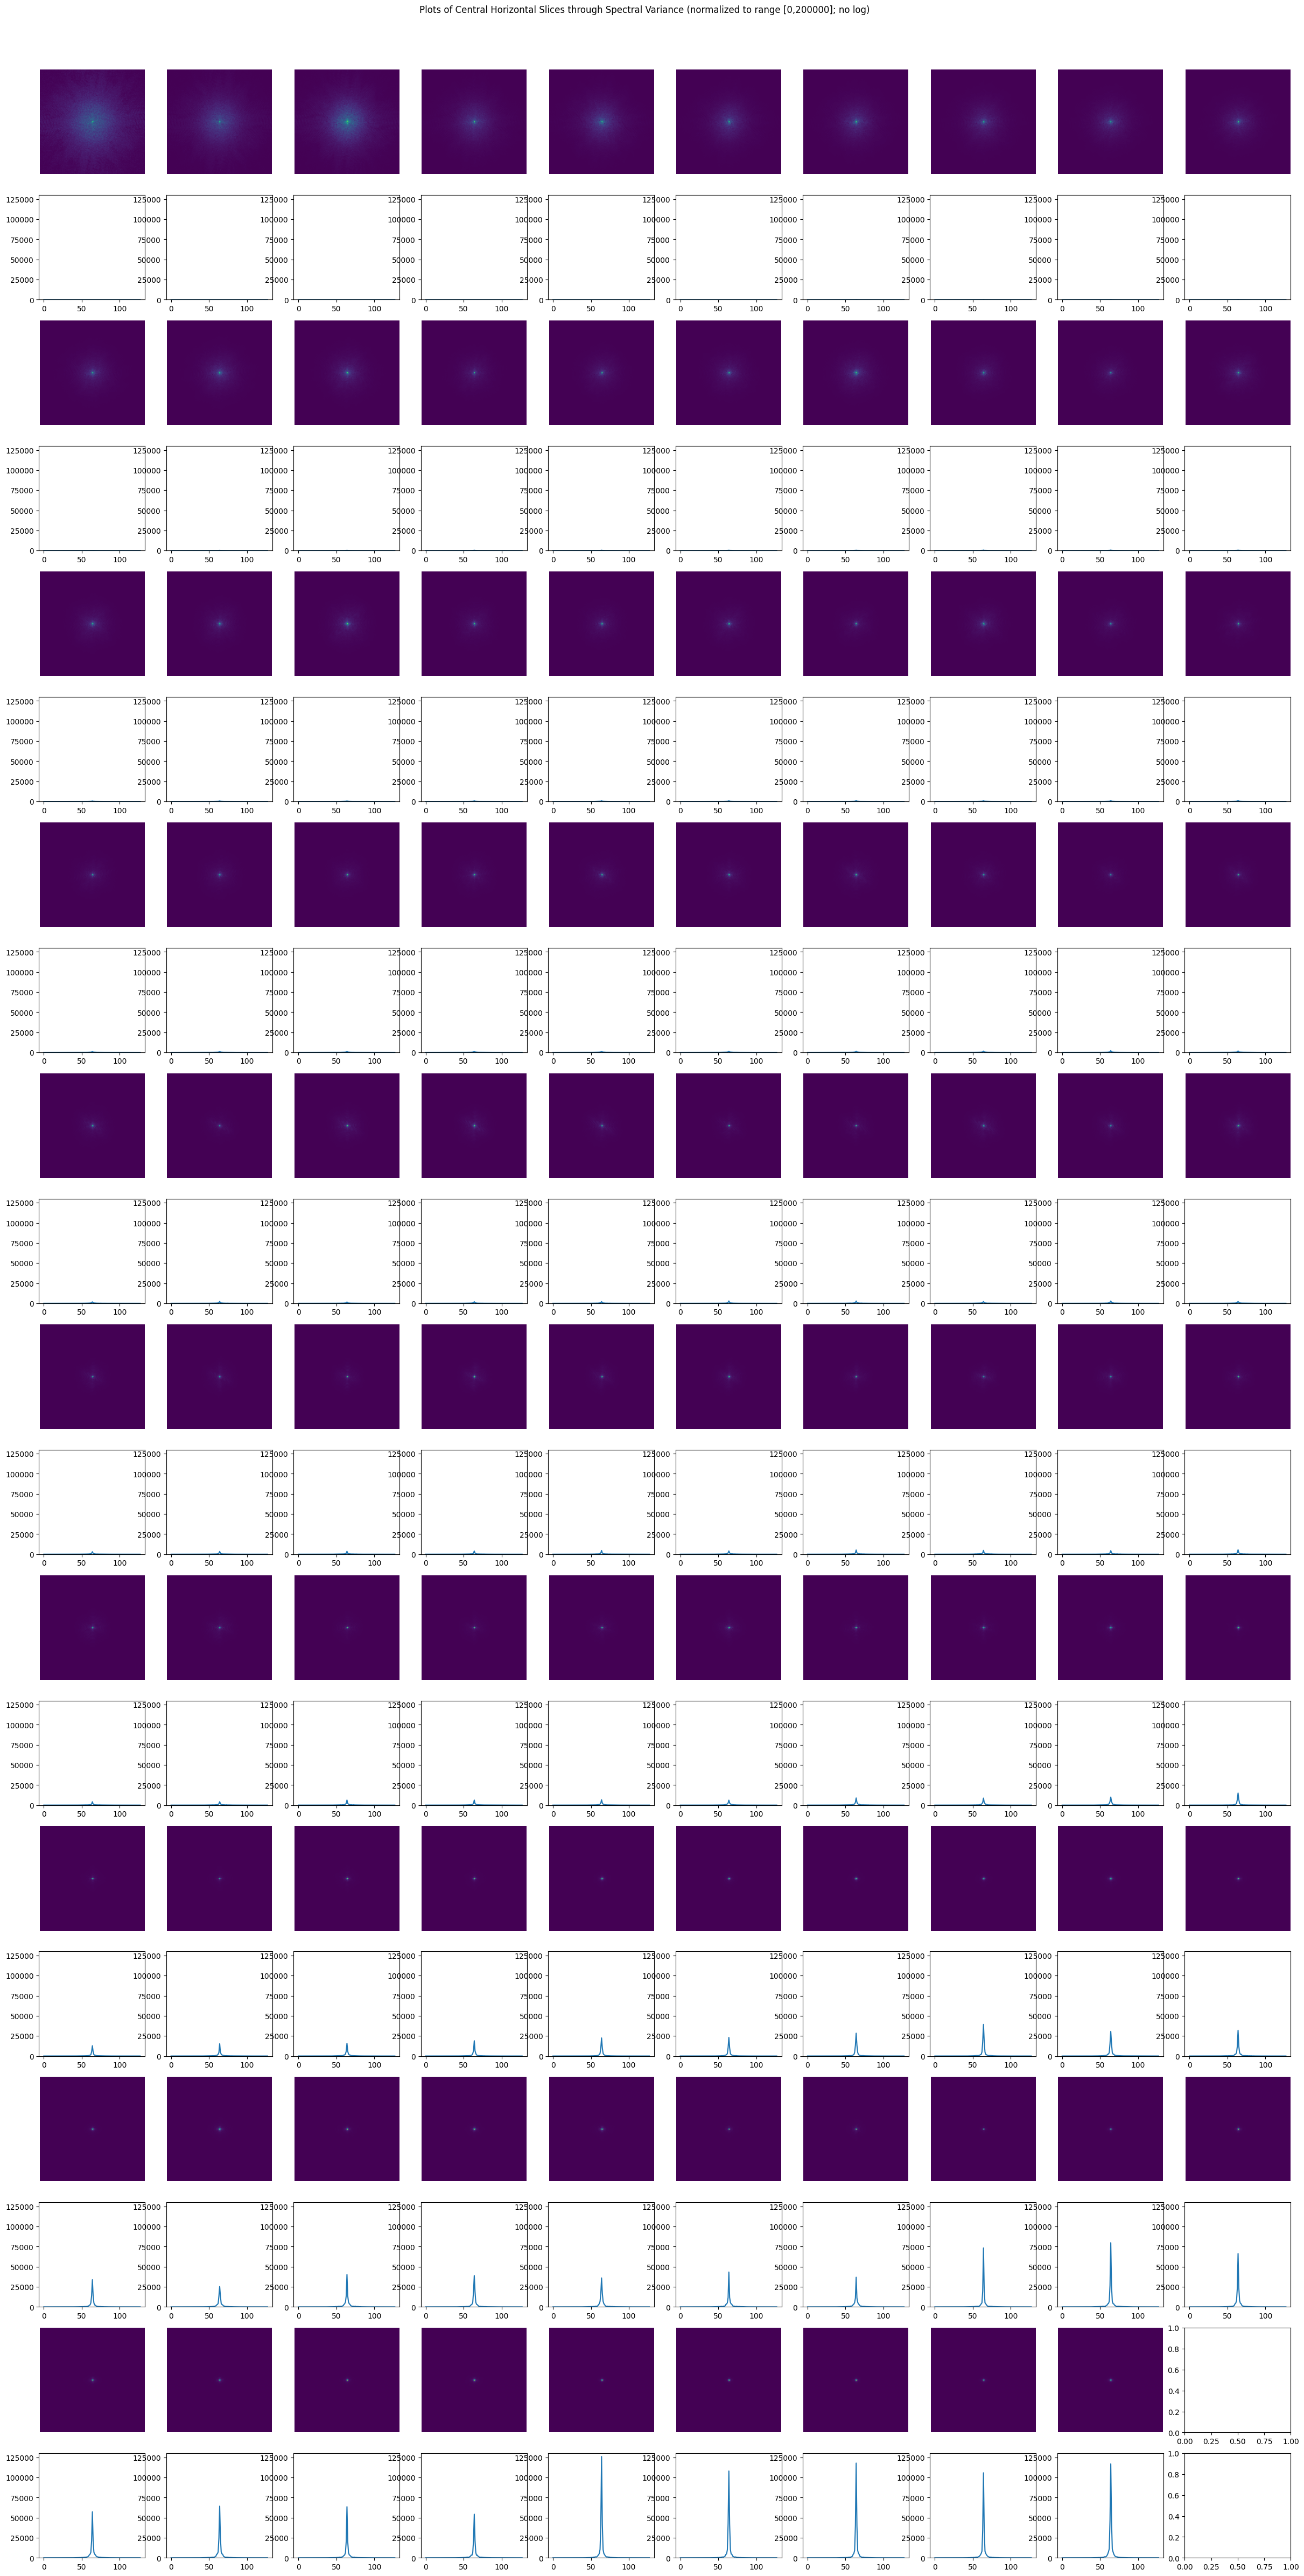

In [8]:
vars = torch.zeros((99,1,128,128))
means = torch.zeros((99,1,128,128))
for key, val in outs.items():
    val = torch.abs(fftshift(fftn(val, dim=(2,3)), dim=(2,3)))
    means[key//10-1] = torch.mean(val, dim=0)
    vars[key//10-1] = torch.var(val, dim=0)

middle_slices = []

fig, ax = plt.subplots(20,10, figsize=(30,60))
for i, t in enumerate(vars):
    ax[i//10*2,i%10].imshow(t[0])
    ax[i//10*2,i%10].axis("off")
    middle_slice = torch.mean(t[0][62:66], dim=0)
    ax[i//10*2+1,i%10].plot(middle_slice)
    ax[i//10*2+1,i%10].set_ylim([0,130000])
    middle_slices.append(middle_slice)

fig.suptitle("Plots of Central Horizontal Slices through Spectral Variance (normalized to range [0,200000]; no log)", y=0.90)

Text(0.5, 1.0, 'Max Values in Horizontal Slices')

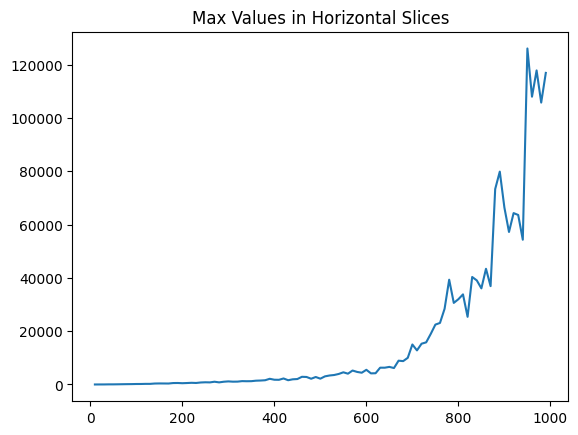

In [4]:
maxes = [elem.max() for elem in middle_slices]
fig, ax = plt.subplots()
x = torch.linspace(10,990,99)
ax.plot(x, maxes)
ax.set_title("Max Values in Horizontal Slices")

In [81]:
class ParzenWindow:
    def __init__(self, L: float=32, size: int=128) -> None:
        assert L < size
        self.L = L
        self.n = torch.arange(-size//2, size//2)
        self.w_0 = torch.zeros_like(self.n)
        for i,elem in enumerate(self.n):
            self.w_0[i] = self.get_w_0(elem - (L-1)/2)

    def get_w_0(self, n):
        if abs(n) <= self.L/4:
            return 1 - 6*(n/(self.L/2))**2 * (1 - abs(n)/(self.L/2))
        if (abs(n) > self.L/4) and (abs(n) <= self.L/2):
            return 2 * (1 - abs(n)/(self.L/2))**3
        else:
            return 0

    def get_space(self):
        return self.w_0
    
    def get_kspace(self):
        return torch.abs(fftshift(fftn(self.w_0, dim=0), dim=0))

    def plot(self):
        plt.plot(self.w_0.detach().numpy())

    def plot_kspace(self):
        plt.plot(torch.abs(fftshift(fftn(self.w_0, dim=0), dim=0)).detach().numpy())

In [5]:
class GaussianFilter2d(nn.Module):
    def __init__(self, size=128, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.sigma = torch.nn.Parameter(torch.tensor(1, dtype=torch.float32))

    def forward(self, x):
        pass

    def _2d_gaussian(self, size: int = 128, normalized_sigma: float = 1):
        x, y = torch.arange(-size//2, size//2), torch.arange(-size//2, size//2)
        x, y = torch.meshgrid([x,y])
        sigma = normalized_sigma*size/2
        return torch.exp(-(x**2)/(2*sigma**2) - (y**2)/(2*sigma**2))

In [25]:
def _2d_gaussian(size: int = 128, normalized_sigma: float = 1):
    x, y = torch.arange(-size//2, size//2), torch.arange(-size//2, size//2)
    x, y = torch.meshgrid([x,y])
    sigma = normalized_sigma*size/2
    filter = torch.exp(-(x**2)/(2*sigma**2) - (y**2)/(2*sigma**2))
    return filter / filter.max()

def _1d_gaussian(size: int = 128, normalized_sigma: float = 1):
    x = torch.arange(-size//2, size//2)
    sigma = normalized_sigma*size/2
    filter = torch.exp(-(x**2)/(2*sigma**2))
    return filter / filter.max()

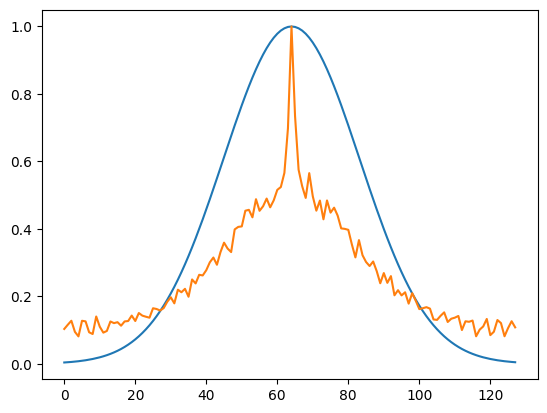

In [35]:
sigma = 0.3
slice = 0

plt.plot(_1d_gaussian(normalized_sigma=sigma))
plt.plot(middle_slices[slice] / middle_slices[slice].max())

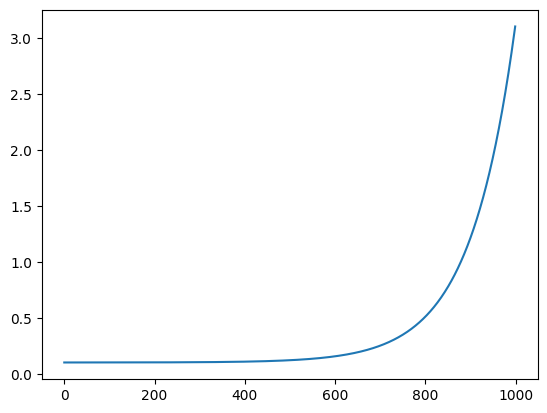

In [121]:
sigmas = torch.linspace(0, 1, 1000)
sigmas = torch.exp(10*sigmas)
sigmas = sigmas / torch.max(sigmas) * 3 + 0.1
plt.plot(sigmas)